# The Alongshore Transporter Class
AlongshoreTransporter is a stand-alone module in BRIE for diffusing sediment along a straight (non-complex) coast. The formulations are detailed in Neinhuis and Lorenzo-Trueba, 2019 [1] and Nienhuis et al., 2015 [2], but stem primarily from the alongshore transport model of Ashton and Murray, 2006 [3]. This notebook provides additional documentation for understanding the functions that comprise AlongshoreTransporter. We first provide AlongshoreTransporter with an arbitrary coastline and then explain the implementation of AlongshoreTransporter within BRIE.

<p float="left">
  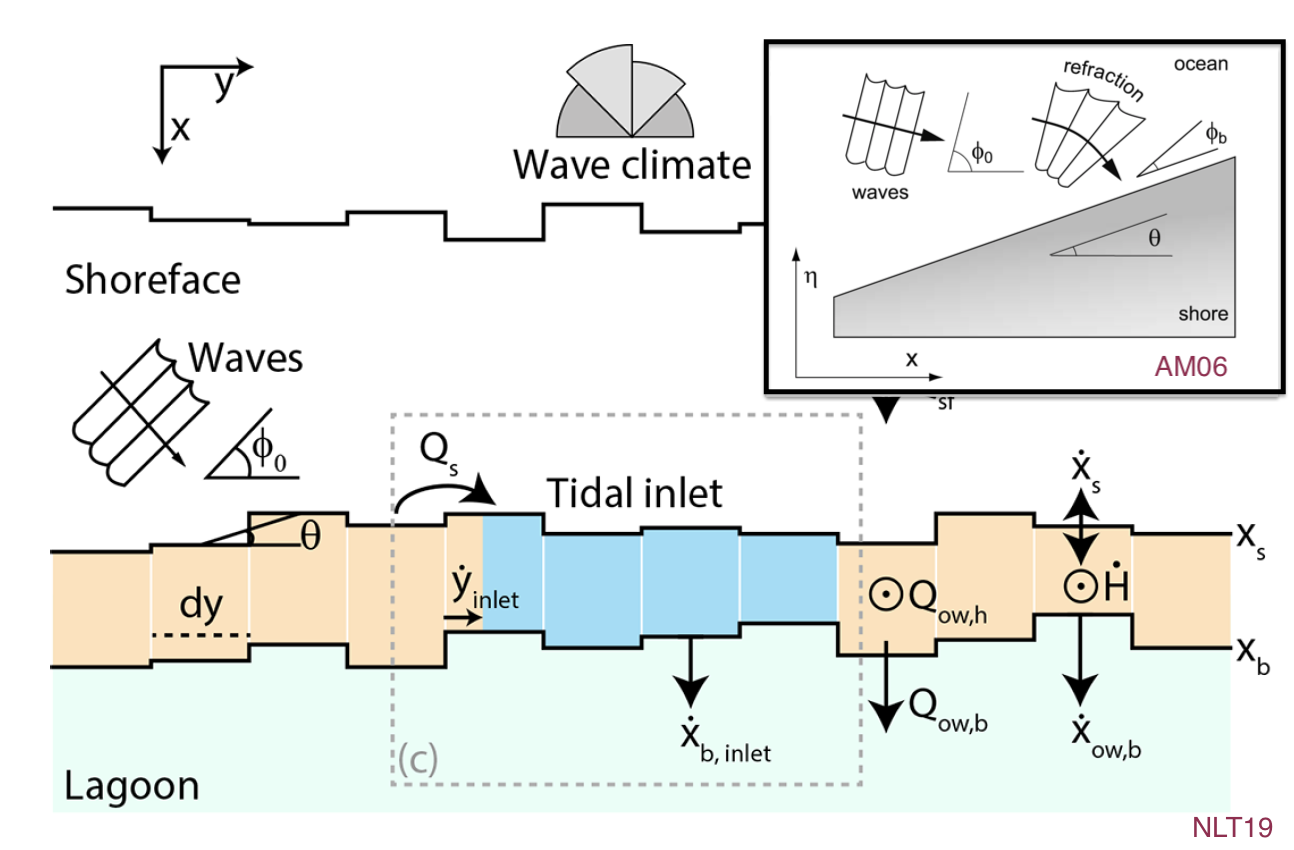
</p>

**Figure 1. Orientation of the coastline for the AlongshoreTransporter class (main figure from NLT19; subset from AM06).**

## Initialization
AlongshoreTransporter must be initialized with a shoreline array; the remaining variables are optional. If a wave distribution is not provided, a uniform distribution is applied from -90 to 90 degrees. Here, we are going to provide the AM06 wave distribution (`ashton`), which divides [0, 1] into quartiles that are uniform distributions defined by the shape parameters $a$ (the asymmetry) and $h$ (high fraction). Here we provide an `ashton` wave energy distribution that is representative of a symmetric wave climate with zero high angle waves.

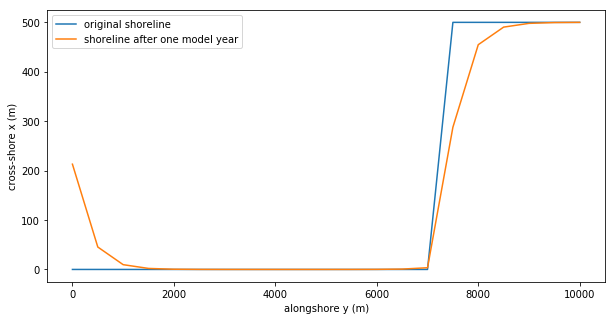

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.constants
import sys
sys.path.append("..")

from brie import Brie
from brie.alongshore_transporter import AlongshoreTransporter, calc_shoreline_angles, calc_coast_diffusivity, _build_matrix
from brie.waves import ashton, WaveAngleGenerator

shoreline_x = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500, 500, 500, 500, 500, 500]  # shoreline array
waves = ashton(a=0.5, h=0, loc=-np.pi/2, scale=np.pi)  # symmetric wave distribution
dy = 500  # alongshore cell (m)
dt = 1  # time step (yr)

# initialize AlongshoreTransporter
transporter = AlongshoreTransporter(shoreline_x, 
                                    wave_distribution=waves, 
                                    alongshore_section_length=dy, 
                                    time_step=dt)  
transporter.update()  # advance one time step

# plot shoreline change after 1 model years
fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
axs.plot(np.arange(0, np.size(shoreline_x)*dy, dy), shoreline_x)  # initial shoreline
axs.plot(np.arange(0, np.size(shoreline_x)*dy, dy), transporter.shoreline_x)
axs.set(xlabel='alongshore y (m)', ylabel='cross-shore x (m)')
axs.legend(["original shoreline", "shoreline after one model year"])

**Figure 2. An example shoreline change after one model year using AlongshoreTransporter for a symmetric wave climate (no high angle waves)**

Once we initialize *AlongshoreTranporter*, we advance the model by one timestep using the `update` function. This example, while ugly, illustrates the periodic boundary conditions used in calculating shoreline diffusivity, explained in more detail below. 

### Wave distribution and shoreline angles
In AM06, the incoming offshore wave angle $\phi_0$ is measured counter-clockwise from the positive x-axis (to the wave front). Hence, a wave angle of -45 degrees corresponds to waves approaching from the right and 45 degrees from the left. From AM06, for a wave asymmetry of 0.8 and highness of 0.2, we are defining a distribution where 80% of the waves approach from the left and 20% of the waves approach at angles higher than 45 degrees (from shore normal). However, if we set asymmetry = 0.8 in the `ashton` distribution, we actually get a wave energy distribution that is left modal (Figure 3): i.e., 80% of the waves come from the RIGHT. What's up with that? This either stems from the orientation of the x axis in BRIE, which is opposite of the coordinate system used in AM06 to define the `ashton` distribution (i.e., $\eta$ in Figure 1 subset), or we just need to always define the `ashton` asymmetry as 1-assymetry. I'll need to come back to this, but for now, I just define asymmetry as 1-0.8 for a wave climate where 80% of the waves approach from the left (note that in Figure 8 of AM06, the x axis spans [90,-90]. Maybe that is the issue!).

[Text(0,0.5,'Wave Energy Distribution ($E$)'),
 Text(0.5,0,'Wave angle ($\\phi_0$)')]

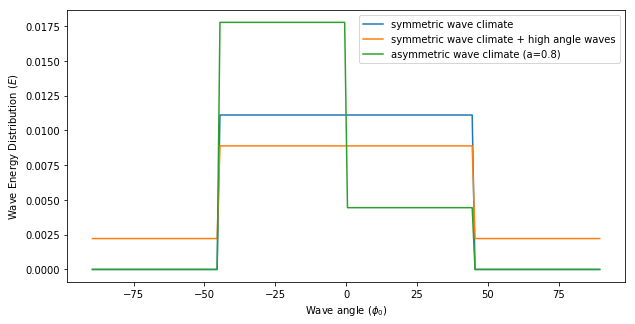

In [2]:
# an example wave angle array
angle_array, step = np.linspace(-89.5, 89.5, 180, retstep=True)  # not including the boundaries

# pdfs
wave_dist_sym = ashton(a=0.5, h=0, loc=-np.pi/2, scale=np.pi)
wave_dist_sym_h = ashton(a=0.5, h=0.2, loc=-np.pi/2, scale=np.pi)
wave_dist_asym_L = ashton(a=0.8, h=0, loc=-np.pi/2, scale=np.pi)
#wave_dist_asym_R = ashton(a=0.2, h=0, loc=-np.pi/2, scale=np.pi)

fig, axs = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
plt.plot(angle_array, wave_dist_sym.pdf(np.deg2rad(angle_array)) * np.deg2rad(step))
plt.plot(angle_array, wave_dist_sym_h.pdf(np.deg2rad(angle_array)) * np.deg2rad(step))
plt.plot(angle_array, wave_dist_asym_L.pdf(np.deg2rad(angle_array)) * np.deg2rad(step))
# plt.plot(angle_array, wave_dist_asym_R.pdf(np.deg2rad(angle_array)) * np.deg2rad(step))
axs.legend(["symmetric wave climate", "symmetric wave climate + high angle waves", "asymmetric wave climate (a=0.8)"])
axs.set(ylabel='Wave Energy Distribution ($E$)', xlabel='Wave angle ($\phi_0$)')

Upon initialization of *AlongshoreTransporter* (i.e., within the `__init__` function), we use the function `calc_shoreline_angles` to calculate the coastline angles of the series of (equally spaced) coastline positions with respect to the *x*-axis ($\theta$ in Figure 1), and from the perspective of looking offshore (from the shoreline). Angles at the first and last points are calculated using wrap-around boundaries. Here we provide another example, a delta ($dy=$100 m), for easy interpretation.

In [3]:
# calculate shoreline angles
shoreline_x = [0, 0, 0, 100, 100, 100, 200, 200, 200, 300, 300, 300, 200, 200, 200, 100, 100, 100, 0, 0, 0]
dy = 100  # m
shoreline_angles = calc_shoreline_angles(shoreline_x, spacing=dy)
print('shoreline angles =', np.rad2deg(shoreline_angles))

shoreline angles = [  0.   0.  45.   0.   0.  45.   0.   0.  45.   0.   0. -45.   0.   0.
 -45.   0.   0. -45.   0.   0.   0.]


## The `update` function

Now lets look under the hood at the functions that are called within `update`. Sediment is diffused along the shoreline using a nonlinear diffusion formulation given by AM06 (Eq. 37-39 in NLT19), which is convolved with the wave climate pdf (the normalized angular distribution of wave energy) to get a *wave-climate averaged shoreline diffusivity* for every alongshore location. Erm, what? Lets break it down. 

Diffusivity $D$ depends on the relative wave angle $\phi_0-\theta$: from AM06, we know that diffisuvity "decreases from a maximum for waves approaching directly onshore, passes through zero at the angle maximizing alongshore sediment transport ($Qs$), and becomes negative for even more oblique wave angles". In *AlongshoreTransporter*, diffusivity is calculated in the function `calc_coast_diffusivity`. For a symmetric wave climate and a straight shoreline (i.e., $\theta=0$), $Qs$ is maximized for waves approaching at $\pm$45 degrees and maximum diffusivity occurs at 0 degrees (Figure 3a). As shown in Figure 3b-c, for assymetric wave climates, maximum diffusivity shifts toward positive (negative) relative wave angles when waves come predominantly from the left (right). Offshore wave climates that include high angle waves ($>\pm 45$ degrees) are less diffusive; this stems from wave refraction, which for waves approaching at a high angle leads to a reduction in wave height as the wave crests becomes stretched. Note that here, the default wave height, period, and berm elevation are used and kept constant for each distribution ($H_0$=1 m, $T_0$=10 sec, berm_ele = 2 m). 

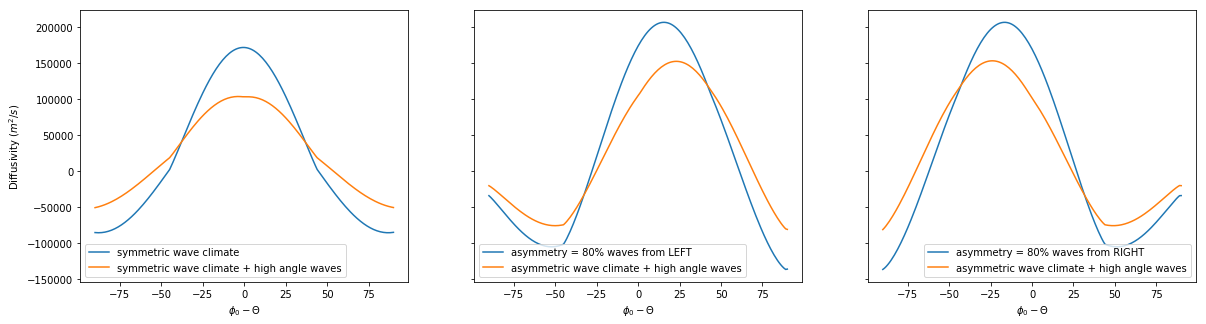

In [4]:
n_bins = 181  # The number of bins used for the wave resolution: if 181, symmetrical about zero, spaced by 1 deg
rel_wave_angles, step = np.linspace(-90, 90, n_bins, retstep=True)  # here, one degree of resolution per bin
fig, axs = plt.subplots(1, 3, figsize=(20, 5), sharey=True)

for ax in axs.flat:
    ax.set(xlabel='$\phi_0 - \Theta$')
    
axs[0].set(ylabel='Diffusivity ($m^2/s$)')

def plot_diffusivity(iAx, assymetry, highness):
    wave_dist = ashton(a=assymetry, h=highness, loc=-np.pi/2, scale=np.pi)
    coast_diff, coast_diff_phi0_theta = calc_coast_diffusivity(wave_dist.pdf, shoreline_angles, n_bins=n_bins)
    axs[iAx].plot(rel_wave_angles, coast_diff_phi0_theta)  # plot diffusivity as a function of relative wave angle
    return wave_dist, coast_diff, coast_diff_phi0_theta

# symmetric wave climate 
waves_sym, coast_diff_sym, coast_diff_phi0_theta_sym = plot_diffusivity(iAx=0, assymetry=0.5, highness=0)
waves_sym_high, coast_diff_sym_high, coast_diff_phi0_theta_sym_high = plot_diffusivity(iAx=0, assymetry=0.5, highness=0.2)
axs[0].legend(["symmetric wave climate", "symmetric wave climate + high angle waves"])

# asymmetric wave climate (80% coming from the LEFT)
waves_asym_left, coast_diff_asym_left, coast_diff_phi0_theta_asym_left = plot_diffusivity(iAx=1, assymetry=0.2, highness=0)
waves_asym_high_left, coast_diff_asym_high_left, coast_diff_phi0_theta_asym_high_left = plot_diffusivity(iAx=1, assymetry=0.2, highness=0.2)
axs[1].legend(['asymmetry = 80% waves from LEFT', 'asymmetric wave climate + high angle waves'])

# asymmetric wave climate (80% coming from the RIGHT)
waves_asym_right, coast_diff_asym_right, coast_diff_phi0_theta_asym_right = plot_diffusivity(iAx=2, assymetry=0.8, highness=0)
waves_asym_high_right, coast_diff_asym_high_right, coast_diff_phi0_theta_asym_high_right = plot_diffusivity(iAx=2, assymetry=0.8, highness=0.2)
axs[2].legend(['asymmetry = 80% waves from RIGHT', 'asymmetric wave climate + high angle waves'])

**Figure 3. Shoreline diffusivity for a) a symmetric wave climate and b-c) asymmetric wave climates.**

What does this mean in terms of shoreline change? In AM06, diffusivity is evaluated for indiviudal wave approach angles (Eq. 8 in AM06) and is not a function of wave assymetry. Here, we are accounting for the fact that when integrated over time, the relative contribution of each wave direction to alongshore sediment transport can be represented by the wave climate pdf. So, the *wave-climate averaged shoreline diffusivity* for every alongshore location is $D(\phi_0-\theta)$ evaluated at $\phi_0=0$ (the distribution mean) minus the shoreline angles (i.e., at the relative wave angles), which gives the the direction of wave-climate averaged coastal diffusion at each alongshore grid cell. Below, we make the diffusion term non-dimensional by multiplying by the time step and alongshore grid discretization (i.e., $\beta$ in Eq.41 of NLT19).

In [5]:
dt = 1  # year
dy = 100  # m
print('relative wave angles =', np.rad2deg(0-shoreline_angles))  # i.e., the mean wave angle (phi_0-shoreline angle)
print('shoreline diffusivity (a=0.5) = ', coast_diff_sym * dt / (2.0 * dy ** 2))
print('shoreline diffusivity (a=80% LEFT) = ', coast_diff_asym_left * dt / (2.0 * dy ** 2))
print('shoreline diffusivity (a=80% RIGHT) = ', coast_diff_asym_right * dt / (2.0 * dy ** 2))

relative wave angles = [  0.   0. -45.   0.   0. -45.   0.   0. -45.   0.   0.  45.   0.   0.
  45.   0.   0.  45.   0.   0.   0.]
shoreline diffusivity (a=0.5) =  [ 8.59636619  8.59636619  0.11044074  8.59636619  8.59636619  0.11044074
  8.59636619  8.59636619  0.11044074  8.59636619  8.59636619 -0.05049086
  8.59636619  8.59636619 -0.05049086  8.59636619  8.59636619 -0.05049086
  8.59636619  8.59636619  8.59636619]
shoreline diffusivity (a=80% LEFT) =  [ 8.70186201  8.70186201 -5.08661035  8.70186201  8.70186201 -5.08661035
  8.70186201  8.70186201 -5.08661035  8.70186201  8.70186201  5.03212755
  8.70186201  8.70186201  5.03212755  8.70186201  8.70186201  5.03212755
  8.70186201  8.70186201  8.70186201]
shoreline diffusivity (a=80% RIGHT) =  [ 8.49087037  8.49087037  5.30749183  8.49087037  8.49087037  5.30749183
  8.49087037  8.49087037  5.30749183  8.49087037  8.49087037 -5.13310928
  8.49087037  8.49087037 -5.13310928  8.49087037  8.49087037 -5.13310928
  8.49087037  8.49087037  

Now that we know the diffusivity at each point, we have all of the variables needed to solve the shoreline diffusion equation (Equation 40 in NLT19). We solve this linear diffusion equation by inverting a nearly tridiagonal matrix, which is created using the `_build_matrix` function. Note that all of the functions we've utilized so far (`calc_coast_diffusivity`, `calc_shoreline_angles`) are called within `_build_matrix`. Figure 3 shows an example of shoreline change for a more realistic shoreline position -- a small delta -- for the wave climate described above, for a 100-m alongshore grid discretization and 1-yr time-step (after one model year).

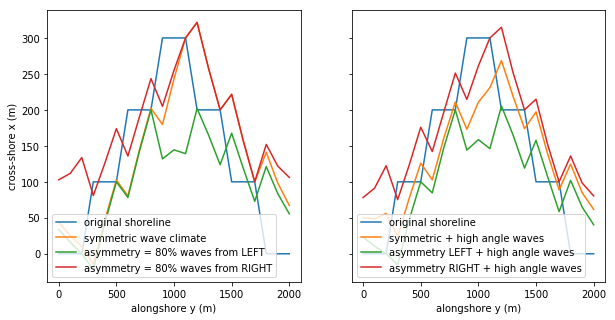

In [6]:
shoreline_x_pyramid_orig = [0, 0, 0, 100, 100, 100, 200, 200, 200, 300, 300, 300, 200, 200, 200, 100, 100, 100, 0, 0, 0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
dy = 100
ny = np.size(shoreline_x_pyramid_orig)
grid = np.arange(0, ny*dy, dy)

for ax in axs.flat:
    ax.set(xlabel='alongshore y (m)')

axs[0].set(ylabel='cross-shore x (m)')
axs[0].plot(grid, shoreline_x_pyramid_orig)
axs[1].plot(grid, shoreline_x_pyramid_orig)

def plot_pyramid(iAx, wave_dist):
    mat, rhs, r_ipl = _build_matrix(shoreline_x_pyramid_orig, wave_dist, dy=100, dt=1.0, dx_dt=0)
    shoreline_x_pyramid = scipy.sparse.linalg.spsolve(mat, rhs)  # invert matrix
    axs[iAx].plot(grid, shoreline_x_pyramid)  # new shoreline
    # print(r_ipl)
    
plot_pyramid(iAx=0, wave_dist=waves_sym)  # symmetric wave climate, no high angle waves
plot_pyramid(iAx=1, wave_dist=waves_sym_high)  # symmetric wave climate, high angle waves
plot_pyramid(iAx=0, wave_dist=waves_asym_left)  # asymmetric wave climate (80% from LEFT), no high angle waves
plot_pyramid(iAx=1, wave_dist=waves_asym_high_left)  # asymmetric wave climate (80% from LEFT), high angle waves
plot_pyramid(iAx=0, wave_dist=waves_asym_right)  # asymmetric wave climate (80% from RIGHT), no high angle waves
plot_pyramid(iAx=1, wave_dist=waves_asym_high_right)  # asymmetric wave climate (80% from RIGHT), high angle waves

axs[0].legend(["original shoreline", "symmetric wave climate", "asymmetry = 80% waves from LEFT", 'asymmetry = 80% waves from RIGHT'], loc='lower left')
axs[1].legend(["original shoreline", "symmetric + high angle waves", 'asymmetry LEFT + high angle waves', "asymmetry RIGHT + high angle waves"], loc='lower left')

**Figure 4. Comparison of shoreline change after one model year for a symmetric and asymmetric wave climate with a) no high angle waves and b) where 20% of the waves come from a high angle ($\pm45$ degrees).**

As you can see in Figure 4a, because we convolved the wave climate pdf (the normalized angular distribution of wave energy) to get a wave-climate averaged shoreline diffusivity for every alongshore location, the difference in shoreline change due to wave asymmetry (for a given wave height and period) is subtle, with slightly more diffusion of the delta by the asymmetric wave climate. 

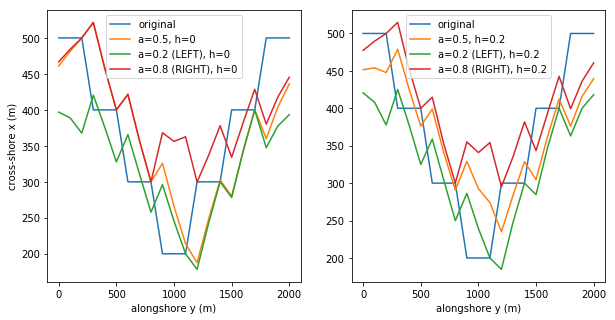

In [7]:
#shoreline_x_pyramid_orig = [0, 0, 0, -100, -100, -100, -200, -200, -200, -300, -300, -300, -200, -200, -200, -100, -100, -100, 0, 0, 0]
shoreline_x_pyramid_orig = [500, 500, 500, 400, 400, 400, 300, 300, 300, 200, 200, 200, 300, 300, 300, 400, 400, 400, 500, 500, 500]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
dy = 100
ny = np.size(shoreline_x_pyramid_orig)
grid = np.arange(0, ny*dy, dy)

for ax in axs.flat:
    ax.set(xlabel='alongshore y (m)')

axs[0].set(ylabel='cross-shore x (m)')
axs[0].plot(grid, shoreline_x_pyramid_orig)
axs[1].plot(grid, shoreline_x_pyramid_orig)

def plot_pyramid(iAx, wave_dist):
    mat, rhs, r_ipl = _build_matrix(shoreline_x_pyramid_orig, wave_dist, dy=100, dt=1.0, dx_dt=0)
    shoreline_x_pyramid = scipy.sparse.linalg.spsolve(mat, rhs)  # invert matrix
    axs[iAx].plot(grid, shoreline_x_pyramid)  # new shoreline
    
plot_pyramid(iAx=0, wave_dist=waves_sym)  # symmetric wave climate, no high angle waves
plot_pyramid(iAx=1, wave_dist=waves_sym_high)  # symmetric wave climate, high angle waves
plot_pyramid(iAx=0, wave_dist=waves_asym_left)  # asymmetric wave climate (80% from LEFT), no high angle waves
plot_pyramid(iAx=1, wave_dist=waves_asym_high_left)  # asymmetric wave climate (80% from LEFT), high angle waves
plot_pyramid(iAx=0, wave_dist=waves_asym_right)  # asymmetric wave climate (80% from RIGHT), no high angle waves
plot_pyramid(iAx=1, wave_dist=waves_asym_high_right)  # asymmetric wave climate (80% from RIGHT), high angle waves

axs[0].legend(["original", "a=0.5, h=0", "a=0.2 (LEFT), h=0", "a=0.8 (RIGHT), h=0"])
axs[1].legend(["original", "a=0.5, h=0.2", "a=0.2 (LEFT), h=0.2", "a=0.8 (RIGHT), h=0.2"])

Now, because I don't really know which way is up here, I'm going to run the first case for 5 years

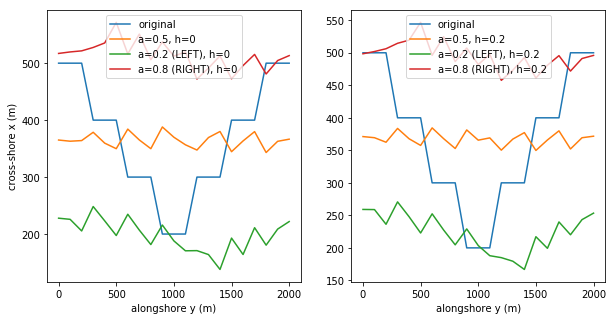

In [8]:
#shoreline_x_pyramid_orig = [0, 0, 0, -100, -100, -100, -200, -200, -200, -300, -300, -300, -200, -200, -200, -100, -100, -100, 0, 0, 0]
shoreline_x_pyramid_orig = [500, 500, 500, 400, 400, 400, 300, 300, 300, 200, 200, 200, 300, 300, 300, 400, 400, 400, 500, 500, 500]

nt = 5  # 5 year simulation

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
dy = 100
ny = np.size(shoreline_x_pyramid_orig)
grid = np.arange(0, ny*dy, dy)

for ax in axs.flat:
    ax.set(xlabel='alongshore y (m)')

axs[0].set(ylabel='cross-shore x (m)')
axs[0].plot(grid, shoreline_x_pyramid_orig)
axs[1].plot(grid, shoreline_x_pyramid_orig)

def loop_transporter(iAx, wave_dist, nt):
    transporter = AlongshoreTransporter(shoreline_x_pyramid_orig, 
                                    wave_distribution=wave_dist, 
                                    alongshore_section_length=dy, 
                                    time_step=1)  
    for year in range(nt):
        transporter.update()  # advance one time step
    
    axs[iAx].plot(grid, transporter.shoreline_x)  # new shoreline after loop
    
loop_transporter(iAx=0, wave_dist=waves_sym, nt=nt)  # symmetric wave climate, no high angle waves
loop_transporter(iAx=1, wave_dist=waves_sym_high, nt=nt)  # symmetric wave climate, high angle waves
loop_transporter(iAx=0, wave_dist=waves_asym_left, nt=nt)  # asymmetric wave climate (80% from LEFT), no high angle waves
loop_transporter(iAx=1, wave_dist=waves_asym_high_left, nt=nt)  # asymmetric wave climate (80% from LEFT), high angle waves
loop_transporter(iAx=0, wave_dist=waves_asym_right, nt=nt)  # asymmetric wave climate (80% from RIGHT), no high angle waves
loop_transporter(iAx=1, wave_dist=waves_asym_high_right, nt=nt)  # asymmetric wave climate (80% from RIGHT), high angle waves

axs[0].legend(["original", "a=0.5, h=0", "a=0.2 (LEFT), h=0", "a=0.8 (RIGHT), h=0"])
axs[1].legend(["original", "a=0.5, h=0.2", "a=0.2 (LEFT), h=0.2", "a=0.8 (RIGHT), h=0.2"])

# Implementation in BRIE model

LEFT OFF HERE: Make a note here that you can update the wave height or parameters at any time.

Text(0.5,0,'time (yr)')

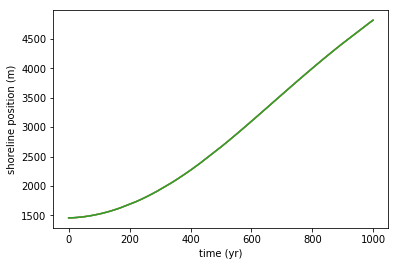

In [13]:
dt=0.05  # yr, timestep 
nt=1000  # years
nt=int(nt/dt) # equivalent to 1000 years
dtsave=int(1/dt)  # save spacing (equivalent of yearly for 0.05 time step)
dy=100
ny=1000
    
brie_asym_pt2 = Brie(
    inlet_model=False,
    wave_height=1,
    wave_period=10,
    wave_asymmetry=0.2,
    wave_angle_high_fraction=0.2,
    sea_level_rise_rate=0.003,
    barrier_height_critical=2,
    barrier_width_critical=450,
    max_overwash_flux=30,
    alongshore_section_length=dy,
    alongshore_section_count=ny,
    time_step=dt,
    time_step_count=nt,
    save_spacing=dtsave
    ) 

brie_asym_pt8 = Brie(
    inlet_model=False,
    wave_height=1,
    wave_period=10,
    wave_asymmetry=0.8,
    wave_angle_high_fraction=0.2,
    sea_level_rise_rate=0.003,
    barrier_height_critical=2,
    barrier_width_critical=450,
    max_overwash_flux=30,
    alongshore_section_length=dy,
    alongshore_section_count=ny,
    time_step=dt,
    time_step_count=nt,
    save_spacing=dtsave
    ) 

brie_asym_pt5 = Brie(
    inlet_model=False,
    wave_height=1,
    wave_period=10,
    wave_asymmetry=0.5,
    wave_angle_high_fraction=0.2,
    sea_level_rise_rate=0.003,
    barrier_height_critical=2,
    barrier_width_critical=450,
    max_overwash_flux=30,
    alongshore_section_length=dy,
    alongshore_section_count=ny,
    time_step=dt,
    time_step_count=nt,
    save_spacing=dtsave
    ) 

for year in range(nt-1):
    brie_asym_pt2.update()  # advance one time step
    brie_asym_pt5.update()
    brie_asym_pt8.update()

plt.plot(np.arange(0, int(nt*dt), int(dtsave*dt)), brie_asym_pt2._x_s_save[5,:])
plt.plot(np.arange(0, int(nt*dt), int(dtsave*dt)), brie_asym_pt5._x_s_save[5,:])
plt.plot(np.arange(0, int(nt*dt), int(dtsave*dt)), brie_asym_pt8._x_s_save[5,:])
plt.ylabel('shoreline position (m)') 
plt.xlabel('time (yr)')

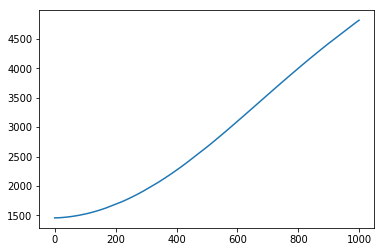